## Keras approach to create a data-driven daily yield curve
Written by Charles Elkan in January and February 2021.

Approach:
1. Train a machine learning (ML) model using Keras to predict the yield of a trade, using a few months worth of data.
2. The predictions of this model for non-callable Texas bonds are the baseline yield curve, independent of any particular day.
3. The average prediction error each day is the estimated shift in the level of the yield curve for that day.

We choose Texas because it is the largest state with a AAA rating.
In its first half, this notebook is similar to the non-ML notebook, creating the dataset,
but here we use a much larger set of trades, including for callable bonds.
The ML part begins after a new title.
Note that experiments with Catboost are in a different notebook.

In [1]:
import os
# the following line uses credentials from a GCP service account
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../eng-reactor-287421-112eb767e1b3.json"

import csv
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from google.cloud import bigquery
from google.cloud import bigquery_storage
import pyarrow
bq_client = bigquery.Client()
bqstorage_client = bigquery_storage.BigQueryReadClient()

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

The SQL query allows for any maturity and any coupon.
We include all three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P).
Generally, yields for S trades are lower (dollar prices are higher) and yields for P trades are higher.
There is no minimum trade quantity, because predicted yields will depend on quantity.

The query uses the full nested ICE data. The _xref_ field is unpacked into multiple rows
in order to make its _text_ subfield available for comparison with the _cusip_ field of the trade data.
The time and cost of a BigQuery query tend to be proportional to the size of the output,
i.e., the number of columns and rows. Complex logic requiring indices, as below, is usually not expensive.

Recently Google made it faster to retrieve data from BigQuery into a pandas dataframe.
The _get_data_ lines that are commented out are retrieval methods that were faster in the past,
but no longer are.

In [2]:
def get_data_ice():
    query = """
            select 
                msrb.cusip,
                msrb.trade_date,
                ifnull(msrb.settlement_date,msrb.assumed_settlement_date) as settle_date, 
                msrb.maturity_date, 
                nested.instrument.debt.call_details.next_call_date as call_date,
                nested.instrument.debt.sink_details.next_sink_date as sink_date,
                nested.instrument.master_information.instrument_master.delivery_date as deliv_date,
                nested.instrument.debt.muni_details.refund_date as refund_date,
                msrb.coupon,
                msrb.trade_type,
                msrb.yield as ytw,
                msrb.dollar_price as price,
                msrb.par_traded as quantity,
                nested.instrument.debt.call_details.call_schedule[SAFE_ORDINAL(1)].call_date as sched_date,
--                nested.instrument.debt.additional_sink_details.next_sink_date as addl_date,
                nested.instrument.master_information.organization_master.primary_name as issuer,
            from eng-reactor-287421.reference_data.nested_ice_ref_snapshot_20210111 as nested,
            unnest(nested.instrument.master_information.instrument_xref.xref) as xref
            inner join eng-reactor-287421.MSRB.msrb_trade_messages as msrb
            on msrb.cusip = xref.text
            where 
                msrb.trade_date >= "2020-10-15"
                and msrb.yield is not null
                and msrb.par_traded is not null
--                and ifnull(ARRAY_LENGTH(nested.instrument.debt.call_details.call_schedule),0) = 0
                and nested.instrument.master_information.organization_master.primary_name like '% ST'
                and nested.instrument.debt.muni_details.conduit_obligor_name is null
                and nested.instrument.master_information.instrument_master.federal_tax_status = 2
            order by msrb.maturity_date asc;
            """
    return bq_client.query(query).result()

%time rawdf = get_data_ice().to_dataframe()
# %time rawdf = get_data_ice().to_arrow(bqstorage_client=bqstorage_client).to_pandas()
# %time rawdf = get_data_ice().to_dataframe(bqstorage_client=bqstorage_client)
# %time rawdf = get_data_ice().to_arrow(bqstorage_client=bqstorage_client).to_pandas()
len(rawdf)

CPU times: user 434 ms, sys: 95.6 ms, total: 530 ms
Wall time: 10.8 s


142760

Converting columns to the correct type and some other standard preprocessing.

In [3]:
df = rawdf.copy()
df.quantity = df.quantity.astype(float)
df.coupon = df.coupon.astype(float)

df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y-%m-%d')
df['settle_date'] = pd.to_datetime(df['settle_date'], format='%Y-%m-%d')
df['maturity_date'] = pd.to_datetime(df['maturity_date'], format='%Y-%m-%d')
df['call_date'] = pd.to_datetime(df['call_date'], format='%Y-%m-%d')
df['sink_date'] = pd.to_datetime(df['sink_date'], format='%Y-%m-%d')
df['deliv_date'] = pd.to_datetime(df['deliv_date'], format='%Y-%m-%d')
df['sched_date'] = pd.to_datetime(df['sched_date'], format='%Y-%m-%d')

rd = pd.to_datetime(df['refund_date'], format='%Y-%m-%d')
rd[rd < df.trade_date] = pd.NaT
df['refund_date'] = rd
 
ratings = dict(csv.reader(open('SPstatecreditratings.csv')))
df.issuer = df.issuer.str[:-3]
df['rating'] = df.issuer.apply(lambda x: ratings[x])

df = df[~df.issuer.isin(["ILLINOIS", 'NEW JERSEY'])] # , 'CONNECTICUT'])]
print(len(df))

131422


To calculate the end date of a bond, we use the refund date, if it is known.
Otherwise, if the next call date is known, we use it.
Otherwise, we use the maturity date.
We ignore sink dates and the call schedule for this calculation.

Not many non-callable bonds with maturities over 10 years exist;
only South Carolina issues such bonds over 12 years.
If included, these can influence the fit of a continuous model too much.
Catboost is robust to outliers in training data, so for it they are not removed.
Somewhat surprisingly, removing them has no clear benefit for neural network models.

In [4]:
df = df.copy()
df['end_date'] = df.refund_date
df.end_date.fillna(df.call_date, inplace=True)
df.end_date.fillna(df.maturity_date, inplace=True)

df['callable'] = ~df.call_date.isnull()
df['called'] = ~df.refund_date.isnull()
df['sinking'] = ~df.sink_date.isnull()
df['whenissued'] = df.deliv_date >= df.trade_date

df['years'] = (df['end_date'] - df['settle_date']).dt.days/365.25
df['maturity'] = (df['maturity_date'] - df['settle_date']).dt.days/365.25
print(len(df), df.years.min(), df.years.max())

# maxyears = 10
# df = df[df.years < maxyears]
# minyears = 0
# df = df[df.years > minyears]
# print(len(df))

131422 -0.0027378507871321013 19.173169062286107


Our goal is to produce a yield curve for non-callable bonds,
but we reduce noise in the model by also including callable bonds in the training data.
We also include bonds with a refund date and with a sink date,
because the model can learn that these tend to trade at different yields.
Among trades for bonds with no next call date, fewer than 3% are for bonds with a refund date or a sink date.
There is no need to use the delivery date to exclude when-issued trades.

In [5]:
# df = df[df.call_date.isnull()]
# print(len(df))
# df = df[df.refund_date.isnull()]
# df = df[df.sink_date.isnull()]
# df = df[df.trade_date > df.deliv_date]

df = df.drop(columns = ['settle_date','maturity_date','call_date','refund_date','sink_date','deliv_date','sched_date','price'])
print(len(df))

131422


Some trades have negative yields, including some for notional amounts $500,000 and over.
Rather than investigate these further, we will exclude them for now.
Many of the large negative yields may be calculation mistakes made by MSRB,
which can be due to erroneous reference data and/or to applying the wrong formula.

In [6]:
df[(df.ytw <= 0) & (df.quantity >= 5e5)]

,cusip,trade_date,coupon,trade_type,ytw,quantity,issuer,rating,end_date,callable,called,sinking,whenissued,years,maturity
8479,882724SY4,2021-01-21,4.0,S,-0.044,500000.0,TEXAS,AAA,2021-08-26,False,False,False,False,0.583162,0.583162
24077,83710DY36,2020-12-18,2.0,D,-6.954,855000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.131417,2.272416
24078,83710DY36,2020-12-21,2.0,D,-4.670,600000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.128679,2.269678
24079,83710DY36,2020-12-21,2.0,D,-5.325,600000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.128679,2.269678
24080,83710DY36,2020-12-22,2.0,D,-6.241,600000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.125941,2.266940
24081,83710DY36,2020-12-18,2.0,P,-6.530,855000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.131417,2.272416
24085,83710DY36,2020-12-22,2.0,S,-9.503,600000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.125941,2.266940
24141,83710DY36,2020-12-18,2.0,S,-13.574,500000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.131417,2.272416
24142,83710DY36,2020-12-18,2.0,S,-13.574,500000.0,SOUTH CAROLINA,AA+,2021-02-08,True,False,False,False,0.131417,2.272416
60122,649791AU4,2021-01-28,4.0,D,-9.225,500000.0,NEW YORK,AA+,2021-02-08,True,False,False,False,0.019165,5.998631


To investigate yields that are suspiciously high, we define a field that captures the approximate dollar value of the excessive yield.
This formula uses 2.5% as the threshold for being excessive.
Then we find the trades with the largest discrepancy. 
Only the trades at yields over 3% look like true anomalies.

In [7]:
df['delta'] = (df.ytw - 2.5) * df.quantity * df.years / 100
df[df.delta >= 1000].sort_values('delta',ascending=False)

,cusip,trade_date,coupon,trade_type,ytw,quantity,issuer,rating,end_date,callable,called,sinking,whenissued,years,maturity,delta
53009,97705L6X0,2021-01-11,5.0,S,33.824,685000.0,WISCONSIN,AA,2024-11-01,True,False,False,False,3.800137,5.295003,815393.092950
58597,13063DFJ2,2020-11-10,5.0,S,61.003,50000.0,CALIFORNIA,AA-,2026-04-01,True,False,False,False,5.379877,5.880903,157369.466119
135991,13063B3X8,2020-11-02,5.0,P,3.787,1000000.0,CALIFORNIA,AA-,2023-04-01,True,False,False,False,2.403833,22.403833,30937.330595
135992,13063B3X8,2020-11-02,5.0,P,3.787,1000000.0,CALIFORNIA,AA-,2023-04-01,True,False,False,False,2.403833,22.403833,30937.330595
131078,20772KLF4,2020-10-22,3.0,D,2.580,2000000.0,CONNECTICUT,A,2030-06-01,True,False,False,False,9.596167,19.597536,15353.867214
89569,60412AQW6,2020-11-13,5.0,P,14.240,15000.0,MINNESOTA,AAA,2029-08-01,True,False,False,False,8.703628,9.702943,15327.088296
40194,594612CQ4,2020-11-18,5.0,P,4.999,50000.0,MICHIGAN,AA,2024-11-01,False,False,False,False,3.950719,3.950719,4936.422998
40195,594612CQ4,2020-11-18,5.0,P,4.999,50000.0,MICHIGAN,AA,2024-11-01,False,False,False,False,3.950719,3.950719,4936.422998
8691,882724SY4,2020-10-29,4.0,S,3.975,300000.0,TEXAS,AAA,2021-08-26,False,False,False,False,0.821355,0.821355,3634.496920
23295,575824AE7,2020-11-13,0.0,P,4.772,45000.0,MASSACHUSETTS,AA,2023-02-01,False,False,True,False,2.206708,2.206708,2256.137988


Interestingly, the cusip 882724SY4 in the table above, which is from Texas has a very wide range of yields, from negative up to 3.975%.

<AxesSubplot:>

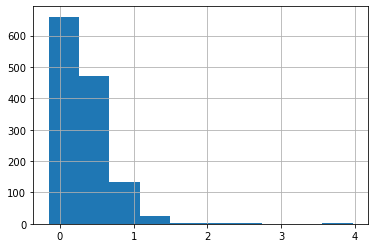

In [8]:
df[df.cusip == '882724SY4'].ytw.hist()

We clean up the data by removing trades with likely wrong yields, under 1% of the data.

In [9]:
print(len(df))
df = df[ (df.ytw > 0) & (df.ytw < 3) ]
print(len(df))

131422
130366


## Training the ML model

This is where the approach here diverges from the previous non-ML approach,
and also from the Catboost approach.
First we make explicit two significant binary flags,
and we add the day of the week as a potential predictor.
Note that binary variables are treated as numerical later.

Then we create the shuffled training dataset and the corresponding target series.
We take the logarithm of the quantity traded in order to reduce its dynamic range.
Finally we restrict the training data to a small number of predictors.

In [10]:
df['california'] = df.issuer == "CALIFORNIA"
df['zerocoupon'] = df.coupon == 0
df['weekday'] = df.trade_date.dt.day_name()

tdf = df.copy().iloc[ np.random.permutation( len(df) ) ]
target = tdf.ytw
tdf['quantity'] = np.log10(tdf.quantity)

binary = ['callable','called','sinking','whenissued','california','zerocoupon']
categorical = ['trade_type','rating','weekday','issuer']
numerical = ['quantity','years','maturity','coupon']
predcols = binary + categorical + numerical
tdf = tdf[predcols]

We define a Keras model that learns vector embeddings for the categorical features.
Preprocessing requires a _LabelEncoder_ for each such feature.

In [11]:
noncat = Input(shape=(len(numerical + binary),), name = "non-categorical")
inputs = [noncat]
layer = [Normalization()(noncat)]

encoders = {}
for f in categorical:
    fprep = LabelEncoder().fit( tdf[f].drop_duplicates() )
    fmax = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    fin = Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = Flatten(name = f + "_flat")( Embedding( fmax+1, 30, input_length=1, name = f + "_embed")( fin ) )
    layer.append(embedded)

hidden = Dense(300, activation='relu')(concatenate(layer))
hidden2 = Dense(100, activation='tanh')(hidden)
final = Dense(1, activation='linear')(hidden2)
model = Model(inputs=inputs, outputs=final)

def mycode(df):
    datalist = [df[numerical + binary].to_numpy().astype('float64')]
    for f in categorical:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float64'))
    return datalist

Alternatively, we define a Keras model that uses one-hot encodings.
The cells immediately above and below are interchangeable.
Each cell has two main outputs: one is its _model_ and the other is a function _mycode_
that transforms a dataframe like _tdf_ into the numerical array that _model_ needs as data.

In [12]:
onehot = OneHotEncoder(sparse=False).fit(tdf[categorical])

def mycode(df):
    data = df[numerical + binary].to_numpy().astype('float64')
    encoded = onehot.transform(df[categorical])
    return np.column_stack([data, encoded]).astype('float64')

encarray = mycode(tdf)
p = encarray.shape[1]

model = Sequential()
model.add(Normalization(input_dim=p))
model.add(Dense(300, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1, activation='linear'))

Now we can train either of the two models defined above with the same code.

In general, there are several important design choices to make training more reliable.
Convergence is faster with _relu_ nonlinearities.
Z-scoring numerical input features also makes training faster.
<!-- We make the first hidden layer wide so that different values for categorical features can have very different effects.
We find that training to minimize MSE is more effective at reducing MAE
than training to minimize MAE directly,
i.e., with MAE as the loss function. -->

Unfortunately, TensorFlow on the Mac M1 has a bug. Using the parameter _sample_weight_, as in the line that is commented out below,
causes the Python kernel to restart near the end of the first epoch, with no error message.

In [13]:
print(model.summary())

m = target.mean()
stdev = target.std()
print("\ntarget mean =", m, "baseline rmse =", stdev, "mse =", stdev**2, "mae =", np.mean(np.abs(target - np.median(target))), "\n")

encarray = mycode(tdf)
w = (tdf.quantity * tdf.years).to_numpy()
w = np.ones(len(target))

model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
history = model.fit(encarray, target, epochs=30, batch_size=64,  verbose=1, validation_split=0.2)

# history = model.fit(encarray, target, sample_weight=w, epochs=30, batch_size=64,  verbose=1, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 59)                119       
_________________________________________________________________
dense_3 (Dense)              (None, 300)               18000     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 48,320
Trainable params: 48,201
Non-trainable params: 119
_________________________________________________________________
None

target mean = 0.7552996563521163 baseline rmse = 0.48468410458037675 mse = 0.2349186812328816 mae = 0.36137185309052977 

Epoch 1/30
1630/1630 [==============================] - 1s 729us/step - loss: 0.0685 - mae: 0.1721 - mse: 0.0685 - val_l

Next we evaluate the bias and accuracy of the model on the training data.
Unfortunately, predictions are often biased, in the mathematical sense that the mean error is not zero,
i.e., errors are systematically in one direction by several basis points.
We try subtracting the mean error, or the median error, to reduce bias.

For each value of each categorical variable, the function _modify_ calculates an amount to add that makes predictions unbiased for the subset of training examples that have this value.
As a consequence, predictions become unbiased over the whole training set.
The additive terms are computed by solving a system of linear equations.
If any value of any variable is equivalent to the union of some values of another variable,
then the system becomes degenerate and does not have a unique solution.
Hence we exclude the _rating_ and _california_ features here.

In [14]:
w.dtype

dtype('float64')

In [15]:
w = np.ones(len(tdf))

In [16]:
# calculate additive terms that make predictions unbiased for all values of categorical features
def modify(preds,tdf):
    values = {}
    N = 0
    features = sorted( set(categorical + binary) - {'rating','california'} )
    for f in features:
        values[f] = sorted(tdf[f].drop_duplicates())
        N += len(values[f])
    coeffs = np.zeros((N,N))
    RHS = np.zeros((N,1))
    i = 0
    for f in features:
        for v in values[f]:
            which = tdf[f] == v
            RHS[i] = np.sum(target[which] - preds[which])
            j = 0
            for g in features:
                for w in values[g]:
                    coeffs[i,j] = np.sum(tdf[which][g] == w)
                    j += 1
            i += 1
    return features, values, np.linalg.solve(coeffs, RHS)

# use the additive terms to adjust baseline predictions for a dataset x
def adjust(x,preds,features,values,terms):
    result = preds.copy()
    i = 0
    for f in features:
        for v in values[f]:
            result[ x[f] == v ] += terms[i]
            i += 1
    return result

We apply the functions just defined to the entire training set, and verify that predictions are now unbiased.
A scatter plot shows that the new predictions are close to the old predictions.
We should investigate the exceptions.

CPU times: user 1.06 s, sys: 115 ms, total: 1.17 s
Wall time: 789 ms
CPU times: user 4.99 s, sys: 142 ms, total: 5.13 s
Wall time: 5.13 s
CPU times: user 200 ms, sys: 262 µs, total: 200 ms
Wall time: 200 ms
0.7550282 0.7552996 0.7552996563521163
0.5315862 0.52342093 0.5234209587955626
0.7242662 0.73218805 0.7321879518072288


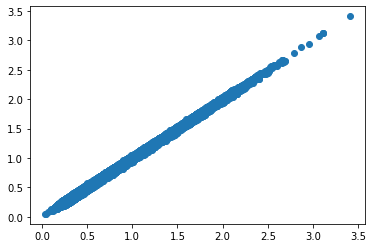

In [17]:
%time preds = model.predict(encarray)
preds = preds.reshape(len(preds))

%time features, values, terms = modify(preds,tdf)
%time newpreds = adjust(tdf,preds,features, values, terms)

print(np.mean(preds), np.mean(newpreds), np.mean(target))
plt.scatter(preds,newpreds)

texas = tdf.issuer == "TEXAS"
print(np.mean(preds[texas]), np.mean(newpreds[texas]), np.mean(target[texas]))

z = tdf.zerocoupon
print(np.mean(preds[z]), np.mean(newpreds[z]), np.mean(target[z]))

callable False [0.00051212]
callable True [-0.00555487]
called False [0.00011412]
called True [0.02213483]
issuer ALABAMA [0.0159456]
issuer ALASKA [0.01524222]
issuer ARKANSAS [0.03983026]
issuer CALIFORNIA [0.01027555]
issuer CONNECTICUT [0.03043854]
issuer DELAWARE [-0.0094209]
issuer FLORIDA [-0.01895622]
issuer GEORGIA [0.00390104]
issuer HAWAII [0.01302632]
issuer LOUISIANA [0.00335805]
issuer MAINE [0.00975463]
issuer MARYLAND [-0.00618771]
issuer MASSACHUSETTS [0.00913292]
issuer MICHIGAN [0.02509022]
issuer MINNESOTA [-0.00349944]
issuer MISSISSIPPI [0.00709488]
issuer MISSOURI [0.05061578]
issuer MONTANA [0.00510285]
issuer NEVADA [0.009855]
issuer NEW HAMPSHIRE [-0.00923908]
issuer NEW MEXICO [0.01585066]
issuer NEW YORK [-0.03677977]
issuer NORTH CAROLINA [0.00521255]
issuer OHIO [0.00107931]
issuer OREGON [-0.00023844]
issuer PENNSYLVANIA [0.00192624]
issuer SOUTH CAROLINA [0.00952354]
issuer TENNESSEE [-0.00417711]
issuer TEXAS [-0.00322338]
issuer UTAH [-0.01381956]
issu

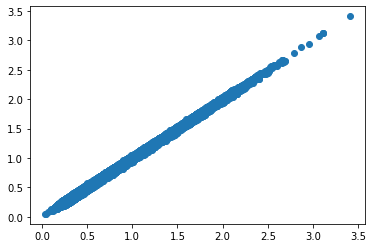

In [18]:
i = 0
for f in features:
    for v in values[f]:
        print(f, v, terms[i])
        i += 1

new = terms.copy()
summ = 0
i = 0
for f in features:
    m = 1e9
    j = i
    for v in values[f]:
        m = min(m,terms[i])
        i += 1
    summ += m
    for v in values[f]:
        new[j] = terms[j] - m
        j += 1
        
print("\nsum m =", summ)
i = 0
for f in features:
    for v in values[f]:
        print(f, v, new[i])
        i += 1

%time newpreds = adjust(tdf,preds,features, values, new) + summ

print(np.mean(preds), np.mean(newpreds), np.mean(target))
plt.scatter(preds,newpreds)

texas = tdf.issuer == "TEXAS"
print(np.mean(preds[texas]), np.mean(newpreds[texas]), np.mean(target[texas]))

z = tdf.zerocoupon
print(np.mean(preds[z]), np.mean(newpreds[z]), np.mean(target[z]))

In [19]:
%time preds = model.predict(encarray)
preds = preds.reshape(len(preds))

error = target - preds
mse = np.mean(error**2)
print("\nerror mean =", error.mean(), "median =", error.median(), "rmse =", np.sqrt(mse), "mae =", np.mean(np.abs(error)))

m = error.mean()
med = error.median()

error = target - (preds + m) 
mse = np.mean(error**2)
print("\nerror mean =", error.mean(), "median =", error.median(), "rmse =", np.sqrt(mse), "mae =", np.mean(np.abs(error)))

error = target - newpreds # (preds + med)
mse = np.mean(error**2)
print("\nerror mean =", error.mean(), "median =", error.median(), "rmse =", np.sqrt(mse), "mae =", np.mean(np.abs(error)))

CPU times: user 1.02 s, sys: 108 ms, total: 1.13 s
Wall time: 756 ms

error mean = 0.00027142581477750544 median = -0.014873322963714602 rmse = 0.1701837178200818 mae = 0.11504100303483716

error mean = -1.0117226181657088e-08 median = -0.015144762516021731 rmse = 0.17018350167192706 mae = 0.11507081774024779

error mean = 2.5829420591541096e-09 median = -0.015262794302828175 rmse = 0.16951461565195172 mae = 0.11481802946419929


Next we visualize the range of true values on the vertical axis, for each predicted value on the horizontal axis.

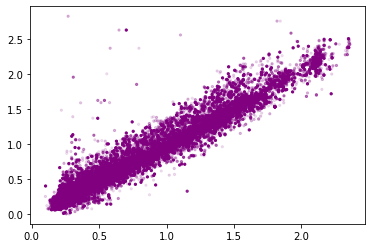

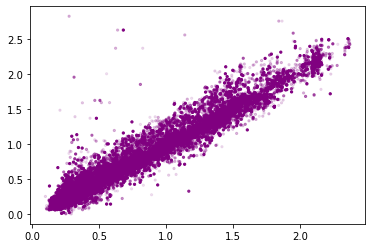

In [20]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 2e6

def drawpoints(target, preds, tdf):
# plot points with transparency depending on size of trade
    r, g, b = to_rgb('purple')
    keep = 10**tdf.quantity > threshold/10  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(df.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    
plt.figure()
drawpoints(target, preds, tdf)

plt.figure()
drawpoints(target, newpreds, tdf)

The best mean absolute error (MAE) achieved on the training data so far using Keras is around 0.11, 
i.e., the typical error in predicting the yield at which a bond will trade is about 11 basis points.
The Catboost model can achieve around 8 basis points.
Our goal for the full ML model is three basis points.
We will reduce error in several major ways:
1. We will predict spread relative to the yield curve,
so changes in this will not introduce error.
Currently, a large part of the eight basis points is due to variation in the overall level of yields
during the months used for training.
2. We will use the history of each individual bond
when predicting the level at which its next trade will happen; 
we will also use the history of similar bonds.
3. We will deal with callability in a more fine-grained and accurate way.
4. The model will take into account many additional characteristics of bonds.
5. We will clean the training data more carefully, to include only independent
and economically meaningful trades.
6. We will create aggregate trades where appropriate, and use trade history
to infer trade types that are more fine-grained.

We could spend a lot of time on hyperparameter search to find the model variant
that yields the lowest error.
However, hyperparameter search is dangerous because it may only achieve overfitting.
Also, it is more useful to spend human time understanding the domain and the problem,
rather than tweaking how an ML algorithm is applied.

The model predicts a different yield curve for each different combination of bond characteristics.
Next we visualize the effect of various alternative feature values.
The yield curves are much smoother than those obtained from Catboost, 
although the latter makes more accurate predictions (in-sample; we have not yet
looked at generalization error carefully).

Another question to investigate is whether Catboost is better at extrapolation.
Tree methods tend to make constant predictions outside the range of training data,
whereas continuous methods tend to have non-zero derivatives and hence to extrapolate to zero or infinity.

In [21]:
tdf['yield'] = target
tdf['pred'] = newpreds
tdf['dollerr'] = (target - newpreds) * 10**tdf.quantity * tdf.years / 100

In [22]:
np.std(tdf.dollerr)/np.sqrt(len(tdf))

30.64726881140618

In [23]:
tdf[tdf.dollerr < -2e5]

,callable,called,sinking,whenissued,california,zerocoupon,trade_type,rating,weekday,issuer,quantity,years,maturity,coupon,yield,pred,dollerr
118522,True,False,False,False,True,False,D,AA-,Thursday,CALIFORNIA,7.397940,9.267625,15.268994,4.0,1.310,1.468858,-368058.885204
124239,True,False,False,False,True,False,P,AA-,Wednesday,CALIFORNIA,7.243038,8.835044,16.835044,4.0,1.330,1.504924,-270456.049099
118564,True,False,False,False,True,False,P,AA-,Tuesday,CALIFORNIA,7.243038,9.240246,15.241615,4.0,1.290,1.460117,-275085.962197
124238,True,False,False,False,True,False,P,AA-,Thursday,CALIFORNIA,7.301030,8.854209,16.854209,4.0,1.364,1.502580,-245403.611136
118560,True,False,False,False,True,False,P,AA-,Thursday,CALIFORNIA,7.397940,9.267625,15.268994,4.0,1.315,1.438763,-286746.828487
118569,True,False,False,False,True,False,S,AA-,Thursday,CALIFORNIA,7.397940,9.267625,15.268994,4.0,1.310,1.436798,-293779.913461
140682,True,False,False,False,True,False,P,AA-,Tuesday,CALIFORNIA,6.975891,6.743326,26.743326,4.0,1.260,1.575045,-200973.407362
118521,True,False,False,False,True,False,D,AA-,Thursday,CALIFORNIA,7.397940,9.267625,15.268994,4.0,1.315,1.468858,-356474.354061
124207,True,False,False,False,True,False,D,AA-,Wednesday,CALIFORNIA,7.243038,8.835044,16.835044,4.0,1.320,1.453992,-207169.296363


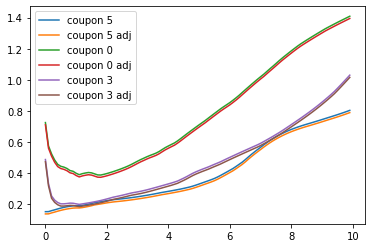

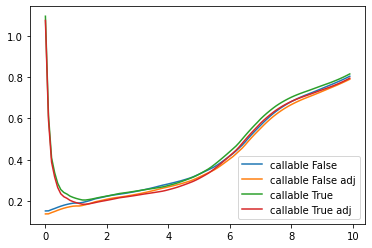

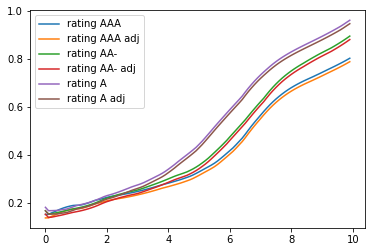

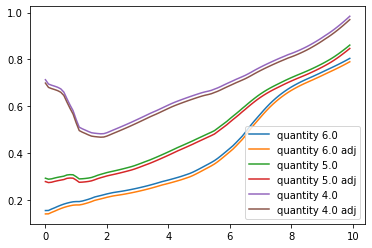

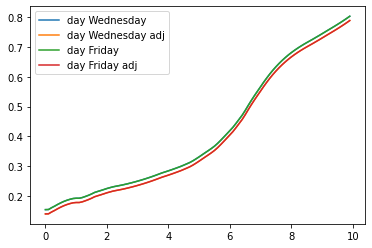

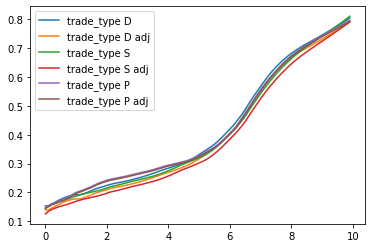

In [24]:
eval = pd.DataFrame(index=range(0,100), columns=tdf.columns)

eval[binary] = False
eval['trade_type'] = "D"
eval['issuer'] = "TEXAS"
eval['rating'] = "AAA"
eval['weekday'] = "Wednesday"
eval['coupon'] = 5
eval['quantity'] = np.log10(1e6)
eval['years'] = np.arange(0,10,.1)
eval['maturity'] = eval.years

eval = eval[tdf.columns]

def evalplot(eval,f,fvals,model):
    plt.figure()
    for c in fvals:
        e = eval.copy()
        e[f] = c
        evalset = mycode(e)
        preds = model.predict(evalset)
        plt.plot(e.years, preds, label = f + " " + str(c))
        preds = adjust(e,preds,features,values,terms)
        plt.plot(e.years, preds, label = f + " " + str(c) + " adj")
    plt.legend()  

evalplot(eval,'coupon', [5, 0, 3], model)
evalplot(eval,'callable', [False, True], model)
evalplot(eval,'rating', ["AAA", "AA-", "A"], model)
evalplot(eval,'quantity', np.log10([1e6, 1e5, 1e4]), model)
evalplot(eval,'day', ["Wednesday", "Friday"], model)
evalplot(eval,'trade_type', ['D', 'S', 'P'], model)

The trends visible in the panels above are mostly as expected. Note that the blue curve is the baseline and is the same in each panel.

Zero coupon bonds command higher rates,
yields are higher for California (A-) than for Texas (AAA),
and higher for smaller trade sizes.
For large trades, the yield curve is monotonically increasing after one year,
but for small trades, yields are higher for durations under five years.
The day of the week is not predictive.
Finally, the last panel shows that dealers tend to purchade at higher yields (i.e., lower prices)
than they sell at.

Now we divide the states into two halves that have approximately equal trade volume and creditworthiness.
The states are sorted by their credit 

In [25]:
v = df.groupby('issuer')
summary = v.mean()
summary['volume'] = v.quantity.sum()
summary['rating'] = v.rating.agg(pd.Series.mode)
summary = summary.sort_values(['volume']).reset_index()

half = set(summary[0::2].issuer) 
half = half - {'WASHINGTON'}
other = set(df.issuer) - set(half)
print(len(half), np.sum(df[df.issuer.isin(half)].quantity), half )
print(len(other), np.sum(df[df.issuer.isin(other)].quantity), other )

17 16745016000.0 {'MISSOURI', 'NORTH CAROLINA', 'GEORGIA', 'ALABAMA', 'OREGON', 'NEVADA', 'MARYLAND', 'MAINE', 'NEW YORK', 'NEW HAMPSHIRE', 'OHIO', 'WISCONSIN', 'CALIFORNIA', 'ARKANSAS', 'VERMONT', 'DELAWARE', 'LOUISIANA'}
18 17007390000.0 {'MINNESOTA', 'PENNSYLVANIA', 'TENNESSEE', 'WASHINGTON', 'SOUTH CAROLINA', 'CONNECTICUT', 'ALASKA', 'WEST VIRGINIA', 'VIRGINIA', 'UTAH', 'MONTANA', 'MASSACHUSETTS', 'TEXAS', 'HAWAII', 'MISSISSIPPI', 'NEW MEXICO', 'FLORIDA', 'MICHIGAN'}


We define a function that compares prediction errors for different values of an independent variable.
The output of the function is a table with one row for each unique value
of the independent variable.
_ym_ is the mean error in predictions for trades with this value, 
and _se_ is the standard error of this mean.
If the absolute value of _ym_ is less than two times _se_ then the mean error 
is not different from zero in a statistically significant way.

As a first example, we compare errors for long and short duration bonds.
With Catboost there is no significant difference,
but with the neural network there is.

In [26]:
sdf = tdf.copy()
sdf['ydiff'] = target - newpreds # error - np.mean(error)

def study(df,dim):   
    g = df.groupby(dim)
    summary = g.mean()
    summary['n'] = g.ydiff.count()
    summary['ym'] = g.ydiff.mean()
    summary['ym'] = round( 100 * summary.ym, 2 )
    summary['se'] = round( 100 * g.ydiff.sem(), 2 )
    return summary.drop(columns = ['ydiff'])[summary.n >= 20]

sdf['long'] = tdf.years > 3
study(sdf,['long'])

,callable,called,sinking,whenissued,california,zerocoupon,quantity,years,maturity,coupon,yield,pred,dollerr,n,ym,se
long,,,,,,,,,,,,,,,,
False,0.464387,0.179106,0.021302,0.009699,0.203840,0.003967,4.581611,1.391958,4.819461,4.646299,0.499898,0.492355,3.618214,50417,0.75,0.09
True,0.672429,0.009143,0.034710,0.045867,0.266595,0.002689,4.665284,6.330744,11.203820,4.523694,0.916360,0.921116,515.046916,79949,-0.48,0.05


We can use the same function to see whether errors depend strongly on other characteristics.
We find that they do not, when using the adjusted predictions.

In [27]:
print("\n", study(sdf,['weekday']))
print("\n", study(sdf,['rating','california']))


            callable    called   sinking  whenissued  california  zerocoupon  \
weekday                                                                       
Friday     0.582029  0.072270  0.028540    0.014960    0.239781    0.002670   
Monday     0.596274  0.079380  0.025766    0.013037    0.245159    0.004204   
Thursday   0.588574  0.067705  0.033055    0.061473    0.240215    0.003561   
Tuesday    0.605156  0.079825  0.029921    0.015944    0.242338    0.002864   
Wednesday  0.585029  0.074482  0.029979    0.051297    0.243756    0.002576   

           quantity     years  maturity    coupon     yield      pred  \
weekday                                                                 
Friday     4.621312  4.425712  8.710959  4.590777  0.746616  0.746616   
Monday     4.591915  4.281739  8.599151  4.578144  0.755081  0.755081   
Thursday   4.670572  4.518668  8.856435  4.564253  0.768800  0.768800   
Tuesday    4.617293  4.415992  8.803351  4.563858  0.757061  0.757061   
Wednes

The two subsets of states are similar to each other, but again the model has bias on each subset.

In [28]:
sdf['half'] = df.issuer.isin(half)
study(sdf,['half'])

,callable,called,sinking,whenissued,california,zerocoupon,quantity,years,maturity,coupon,yield,pred,dollerr,long,n,ym,se
half,,,,,,,,,,,,,,,,,
False,0.596313,0.083491,0.038504,0.047420,0.000000,0.006271,4.634531,4.476431,8.924953,4.515881,0.801041,0.801041,363.828869,0.611893,66175,0.0,0.06
True,0.587497,0.065991,0.020268,0.015859,0.492141,0.000000,4.631268,4.363340,8.538708,4.628045,0.708145,0.708145,269.251608,0.614681,64191,0.0,0.07


Now, we investigate how accurately we can detect the changes in the yield curve from day to day.
Here, _dayN_ is the day of the year with days in 2021 numbered as continuing after days in 2020.
The average error in yield predictions for a given day is our estimate of the change in the level of the yield curve for that day.
By looking at how consistent these changes are for the two disjoint subsets of states,
we can see how accurately the changes track the genuine phenomenon that the level of yields evolves from day to day.

0.9601298701298701 0.7944883079350115 0.9867648615784922


,dayN,half,callable,called,sinking,whenissued,california,zerocoupon,quantity,years,maturity,coupon,yield,pred,dollerr,long,n,ym,se
105,366,False,0.693487,0.061303,0.061303,0.114943,0.000000,0.0,4.586171,4.960314,10.921958,4.159004,0.945858,1.003081,-415.457347,0.678161,261,-5.72,0.78
106,366,True,0.571429,0.060790,0.021277,0.000000,0.525836,0.0,4.524139,3.847521,6.990349,4.652888,0.581967,0.636594,-194.714043,0.513678,329,-5.46,0.72


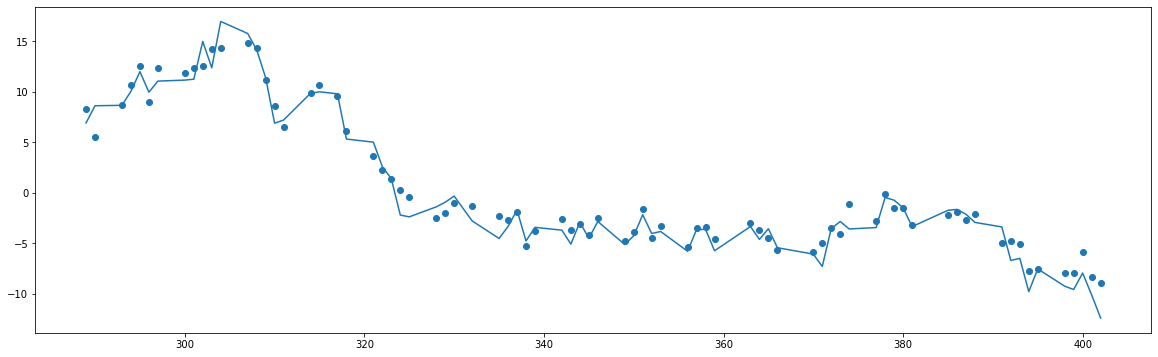

In [29]:
rawday = df.trade_date.dt.dayofyear.copy()
rawday[rawday < 100] = rawday[rawday < 100]+366
sdf['dayN'] = rawday

r = study(sdf,['dayN','half']).reset_index()
days = set(r[r.half].dayN) & set(r[~r.half].dayN)

halfym =  r[ r.dayN.isin(days) & r.half ].ym
otherym = r[ r.dayN.isin(days) & ~r.half ].ym

plt.figure(figsize=(20,6)) 
days = sorted(days)
plt.plot(days,halfym)
plt.scatter(days,otherym)

absd = np.abs(halfym.array - otherym.array)
print(np.mean(absd), np.std(absd), np.corrcoef(halfym,otherym)[0,1])

r[r.dayN == 366]

Next we investigate the idea that an observed error in yield prediction should be weighted lower if the prediction is expected to be noisy,
and higher if the prediction is expected to be accurate.
Specifically, we investigate https://en.wikipedia.org/wiki/Inverse-variance_weighting.

We train a new ML model to predict the squared error of the yield predictions.
Note that the following code assumes that the base model was trained with one-hot encodings,
and uses a neural network design that is appropriate given that.
Do not run this code after training a model that uses embeddings.

In [30]:
esquare = np.abs(error)

m = esquare.mean()
stdev = esquare.std()
print("\nesquare mean =", m, "rmse =", stdev, "mse =", stdev**2, "best mae =", np.mean(np.abs(esquare - np.median(esquare))), "\n")
print("sqerror mean =", "RMSE =, MAE", esquare.mean(), esquare.std(), esquare.mad())

emodel = Sequential()
emodel.add(Normalization(input_dim=p))
# emodel.add(Dense(1000, activation='relu'))
emodel.add(Dense(100, activation='relu'))
emodel.add(Dense(10, activation='relu'))
emodel.add(Dense(1, activation='linear'))
emodel.summary()
emodel.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = emodel.fit(encarray, esquare, epochs=10, batch_size=64,  verbose=1, validation_split=0.2)


esquare mean = 0.11481802946419929 rmse = 0.12470823679934877 mse = 0.015552144325602446 best mae = 0.0771451740345 

sqerror mean = RMSE =, MAE 0.11481802946419929 0.12470823679934877 0.08238583126554297
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 59)                119       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               6000      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 7,140
Trainable params: 7,021
Non-trainable params: 119
_________________________________________________________________
Epoch 1/10
1630/1630 [====================

We need to avoid any weights being too large.
To achieve this, we set a minimum noise level for any prediction.
This minimum is set at 9 basis points, written as (9e-2)**2 because predicted yields are in percentage points.

113708.21674325022 130366 [0.03301571] 1.0 0.775507 [1.]


<AxesSubplot:>

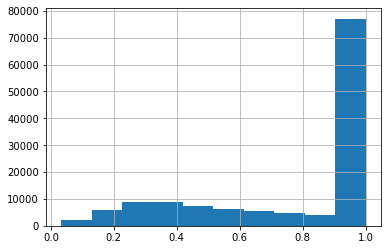

In [31]:
predn = emodel.predict(encarray)
noise = np.maximum(predn, (9e-2))
weights = 1/noise**2
# weights[weights == max(weights)] = 0
weights = weights / np.median(weights)
neff = np.sum(weights)**2 / np.sum(weights**2)
print(neff, len(weights), min(weights), np.median(weights), np.mean(weights), max(weights))

sdf = tdf.copy()
sdf['w'] = weights
sdf.w.hist()

In [32]:
sdf['ydiff'] = error # - np.mean(error) # df.ytw - model.predict(ddf)
sdf['ydiffw'] = sdf.ydiff * sdf.w
sdf['ydiff2w'] = (sdf.ydiff**2) * sdf.w

def study(df,dim):   
    g = df.groupby(dim)
    summary = g.mean()
    summary['n'] = g.ydiff.count()
    summary['ym'] = g.ydiff.mean()
    summary['ymw'] = g.ydiffw.sum() / g.w.sum()
    summary['yvw'] = (g.ydiff2w.sum() / g.w.sum()) - (g.ydiffw.sum() / g.w.sum())**2

    summary['ym'] = round( 100 * summary.ym, 2 )
    summary['se'] = round( 100 * g.ydiff.sem(), 2 )
    summary['ymw'] = round( 100 * summary.ymw, 2 )
    summary['sew'] = round( 100 * np.sqrt(summary.yvw/summary.n), 2 )

    return summary.drop(columns = ['w','ydiff','ydiffw','ydiff2w','yvw'])[summary.n >= 20]

sdf['half'] = df.issuer.isin(half)
study(sdf,['half'])

,callable,called,sinking,whenissued,california,zerocoupon,quantity,years,maturity,coupon,yield,pred,dollerr,n,ym,ymw,se,sew
half,,,,,,,,,,,,,,,,,,
False,0.596313,0.083491,0.038504,0.047420,0.000000,0.006271,4.634531,4.476431,8.924953,4.515881,0.801041,0.801041,363.828869,66175,0.0,0.00,0.06,0.05
True,0.587497,0.065991,0.020268,0.015859,0.492141,0.000000,4.631268,4.363340,8.538708,4.628045,0.708145,0.708145,269.251608,64191,0.0,-0.05,0.07,0.06


0.7714285714285715 0.6811863491736726 0.9877608329826265


,dayN,half,callable,called,sinking,whenissued,california,zerocoupon,quantity,years,maturity,coupon,yield,pred,dollerr,n,ym,ymw,se,sew
105,366,False,0.693487,0.061303,0.061303,0.114943,0.000000,0.0,4.586171,4.960314,10.921958,4.159004,0.945858,1.003081,-415.457347,261,-5.72,-4.06,0.78,0.67
106,366,True,0.571429,0.060790,0.021277,0.000000,0.525836,0.0,4.524139,3.847521,6.990349,4.652888,0.581967,0.636594,-194.714043,329,-5.46,-4.38,0.72,0.65


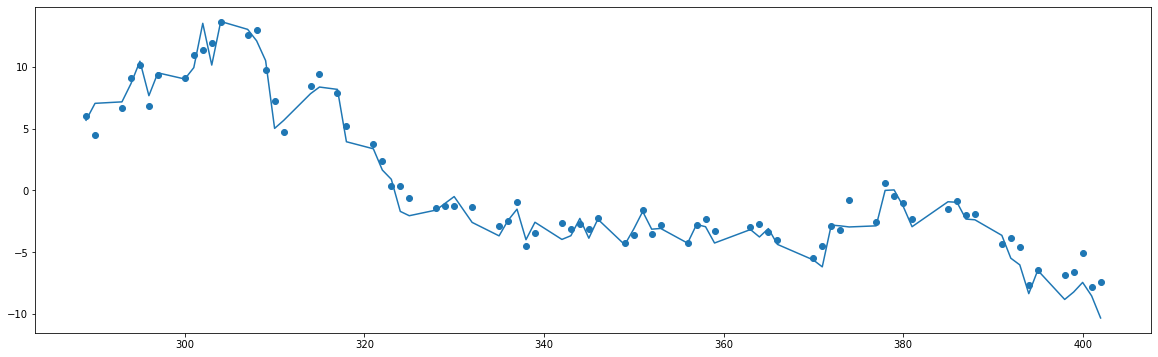

In [33]:
rawday = df.trade_date.dt.dayofyear.copy()
rawday[rawday < 100] = rawday[rawday < 100]+366
sdf['dayN'] = rawday

r = study(sdf,['dayN','half']).reset_index()
days = set(r[r.half].dayN) & set(r[~r.half].dayN)

halfym =  r[ r.dayN.isin(days) & r.half ].ymw
otherym = r[ r.dayN.isin(days) & ~r.half ].ymw

plt.figure(figsize=(20,6)) 
days = sorted(days)
plt.plot(days,halfym)
plt.scatter(days,otherym)

absd = np.abs(halfym.array - otherym.array)
print(np.mean(absd), np.std(absd), np.corrcoef(halfym,otherym)[0,1])

r[r.dayN == 366]

The typical difference of opinion between the two subsets (the value of _absd_) is around 1.0 basis points,
less good than what is achived by Catboost.
It is likely that our ML model overfits the training data to some extent.
Perfect overfitting would be memorizing the training data and thereby achieving zero error.
In this case, _absd_ would be uniformly zero.
The Pearson correlation, over 0.98 above, does not depend on the magnitude of the _absd_ values
so the fact that it is close to one gives us some confidence that the positive result above is not due primarily to overfitting.